In [ ]:
pip install brian2

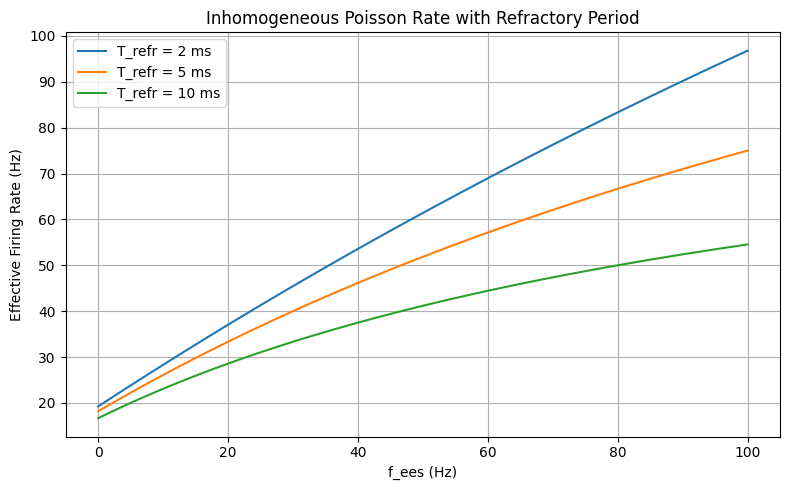

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def inhomogeneous_poisson_refractory(f_aff, f_ees, T_refr):
    return 1 / (1 / (f_aff + f_ees) + T_refr)

# Fixed f_aff
f_aff = 20  # Hz

# Range of f_ees values
f_ees_values = np.linspace(0, 100, 500)  # Hz

# Different refractory times
T_refr_values = [0.002, 0.005, 0.01]  # seconds (2ms, 5ms, 10ms)

# Plotting
plt.figure(figsize=(8, 5))
for T_refr in T_refr_values:
    firing_rates = inhomogeneous_poisson_refractory(f_aff, f_ees_values, T_refr)
    plt.plot(f_ees_values, firing_rates, label=f"T_refr = {T_refr*1000:.0f} ms")

plt.title("Inhomogeneous Poisson Rate with Refractory Period")
plt.xlabel("f_ees (Hz)")
plt.ylabel("Effective Firing Rate (Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[0.002    0.0914   0.125825 0.322075 0.614475 0.675075 0.69565  0.715475
 0.739525 0.758725 0.804425 0.815775 0.8376   0.85355  0.9096   0.92185
 0.99505 ] s
[0.007625 0.0457   0.060125 0.0748   0.1063   0.10705  0.1204   0.155325
 0.215225 0.219625 0.2862   0.322875 0.3995   0.410175 0.4107   0.4119
 0.438375 0.439425 0.501725 0.53185  0.5395   0.584025 0.620375 0.669425
 0.671    0.69705  0.71095  0.724575 0.751575 0.77635  0.78445  0.802475
 0.810375 0.878425 0.884575 0.89315  0.9168   0.92065  0.942675 0.951225
 0.983575] s
Natural frequency 17
EES frequency 41
Final frequency 46


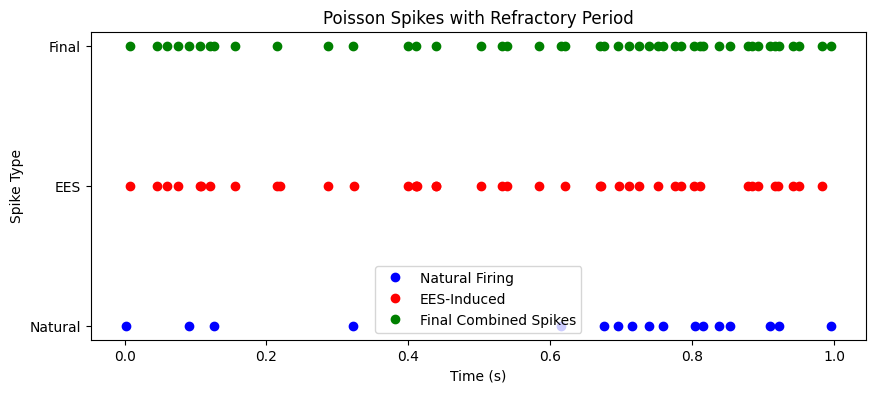

In [ ]:
from brian2 import *

# Parameters
lambda_nat = 20 * Hz  # Natural firing rate
lambda_ees = 50 * Hz  # EES firing rate
T_refr = 5 * ms       # Refractory period
T_max = 1 * second    # Total simulation time


Net=Network()

# Define Poisson spike generators
G_nat = PoissonGroup(1, rates=lambda_nat)  # Natural firing
G_ees = PoissonGroup(1, rates=lambda_ees)  # EES-induced spikes

# Monitors to record spikes
M_nat = SpikeMonitor(G_nat)
M_ees = SpikeMonitor(G_ees)

Net.add(G_nat, G_ees, M_nat, M_ees)
# Run simulation
Net.run(T_max)

# Extract spike times
spike_times_nat = M_nat.spike_trains()[0]
spike_times_ees = M_ees.spike_trains()[0]

def compute_final_firing_rate(spike_times_nat, spike_times_ees, T_refr):
  # Merge and filter spikes based on refractory period
  all_spikes = sorted(np.concatenate((spike_times_nat, spike_times_ees)))*second

  final_spike_train = []
  last_spike_time = 0*ms # Start with no spike

  for spike_time in all_spikes:
      if spike_time - last_spike_time >= T_refr:
          final_spike_train.append(spike_time)
          last_spike_time = spike_time  # Update last valid spike time
  return final_spike_train

final_spike_train=compute_final_firing_rate(spike_times_nat, spike_times_ees, T_refr)
# Print final spike times
print('Natural frequency', len(spike_times_nat))
print('EES frequency', len(spike_times_ees))
print('Final frequency', len(final_spike_train))

# Plot results
figure(figsize=(10, 4))
plot(spike_times_nat, np.ones_like(spike_times_nat), 'bo', label="Natural Firing")
plot(spike_times_ees, np.ones_like(spike_times_ees) * 2, 'ro', label="EES-Induced")
plot(final_spike_train, np.ones_like(final_spike_train) * 3, 'go', label="Final Combined Spikes")
legend()
xlabel("Time (s)")
ylabel("Spike Type")
yticks([1, 2, 3], ["Natural", "EES", "Final"])
title("Poisson Spikes with Refractory Period")
show()


In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

defaultclock.dt = 0.025 * ms

D = 10 * um
internode_length = 100 * D
node_length = 1 * um
n_nodes = 31
n_internodes = 30
n_tot = n_nodes + n_internodes
L = n_nodes * (node_length + internode_length)

EL = -80 * mV
ENa = 60 * mV
EK = -80 * mV

epsilon = 0.1 * um
width = 2 * ms
sigma= 0.1*siemens/meter

# Firing rate computation
def firing_rate(time, voltage):
    threshold = -40
    refractory_ms = 2 * ms
    min_distance_samples = int(refractory_ms / defaultclock.dt)
    peaks, _ = find_peaks(voltage, height=threshold, distance=min_distance_samples)
    total_time_sec = (time[-1] - time[0]) / 1000  # conversion to seconds
    rate = len(peaks) / total_time_sec
    return time[peaks], rate


def create_neuron(ees=False, f=0):


    morpho = Cylinder(diameter=D, length=L, n=n_tot)
    if ees :
        # Define Iees within the equation string using existing variables
        eqs = '''
        Im = INaf + INap + IKs + IL + Iees : amp/meter**2

        Iees = A*I/(4*pi*sigma)*(-2/(xpos)+ 1/(xplus)+ 1/(xminus))*(int(t%(1/fees)<width) ): amp/meter**2
        A = D * n_tot / (4 * L**2 * Ri) : siemens/meter**2
        x0 = L/2 : meter
        xpos = clip(abs(i*L/n_tot-x0), epsilon,L) : meter
        xplus = clip(abs((i+1)*L/n_tot-x0), epsilon,L) : meter
        xminus = clip(abs((i-1)*L/n_tot-x0), epsilon,L) : meter
        '''

    else:
        eqs = 'Im = INaf + INap + IKs + IL : amp/meter**2'

    eqs += '''
    IL = gLK * (EL-v ) : amp/meter**2

    INaf = gNaf * m**3 * h * (ENa-v) : amp/meter**2
    dm/dt = (6.57*10.3/(exprel(-(v+10.4*mV)/(10.3*mV))) * (1-m) -
            0.304*9.16/exprel(+(v+15.7*mV)/(9.16*mV)) * m) /ms: 1
    dh/dt = (0.34*11/exprel(+(v+104*mV)/(11*mV)) * (1-h) -
            12.6/(1 + exp(-(v+21.8*mV)/(13.4*mV))) * h) /ms: 1

    INap = gNap * p**3 * (ENa-v) : amp/meter**2
    dp/dt = (0.0353*10.2/exprel(-(v+17*mV)/(10.2*mV)) * (1-p) -
            0.000883*10/exprel(+(v+24*mV)/(10*mV)) * p) /ms: 1

    IKs = gKs * s * (EK-v) : amp/meter**2
    ds/dt = (0.3/(1 + exp((v+43*mV)/(-5*mV))) * (1-s) -
            0.03/(1+exp((v+80*mV)/(-1*mV)))*s) /ms: 1

    gNap : siemens/meter**2
    gNaf : siemens/meter**2
    gKs : siemens/meter**2
    gLK : siemens/meter**2
    fees : hertz
    '''

    neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=0.1 * uF / cm**2, Ri=70 * ohm * cm, method='exponential_euler')
    neuron.v = -80 * mV
    neuron.gLK = 0.001 * siemens / cm**2
    neuron.fees=f

    for j in range(n_nodes):
        node_start = j * (node_length + internode_length)
        node_end = node_start + node_length
        neuron[node_start:node_end].gNaf = 3 * siemens / cm**2
        neuron[node_start:node_end].gNap = 0.01 * siemens / cm**2
        neuron[node_start:node_end].gKs = 0.08 * siemens / cm**2
        neuron[node_start:node_end].gLK = 0.007 * siemens / cm**2
        neuron[node_start:node_end].Cm = 2 * uF / cm**2


    return neuron


# Simulation function
def simulate(frequency_EES, input_frequency=20*Hz, I=700*uA, T = 5 * second):

    network = Network()

    poisson = PoissonGroup(1, rates=input_frequency)
    neuron_without = create_neuron(ees=False)
    synapse_without = Synapses(poisson, neuron_without[0], on_pre='v += 10*mV')
    synapse_without.connect(p=1)
    mon_without = StateMonitor(neuron_without, 'v', record=[30])

    network.add(poisson, neuron_without, synapse_without, mon_without)

    monitors = [mon_without]

    for frequency in frequency_EES:


        neuron = create_neuron(True, frequency)
        synapse = Synapses(poisson, neuron[0], on_pre='v += 10*mV')
        synapse.connect(p=1)
        mon = StateMonitor(neuron, 'v', record=[30])

        network.add(neuron, synapse, mon)
        monitors.append(mon)

    network.run(T)
    return monitors

WARNING    'v' is an internal variable of group 'spatialneuron_10', but also exists in the run namespace with the value array([-80.        , -86.11785923, -89.31354576, ..., -74.1202743 ,
       -74.13332259, -74.14634143]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'spatialneuron_11', but also exists in the run namespace with the value array([-80.        , -86.11785923, -89.31354576, ..., -74.1202743 ,
       -74.13332259, -74.14634143]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'spatialneuron_12', but also exists in the run namespace with the value array([-80.        , -86.11785923, -89.31354576, ..., -74.1202743 ,
       -74.13332259, -74.14634143]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group '

Natural Firing Rate (no EES): 28.00 Hz
Firing Rate with EES  20. Hz: 31.80 Hz
Firing Rate with EES  30. Hz: 38.80 Hz
Firing Rate with EES  40. Hz: 32.00 Hz
Firing Rate with EES  50. Hz: 35.20 Hz
Firing Rate with EES  60. Hz: 41.60 Hz
Firing Rate with EES  70. Hz: 32.60 Hz
Firing Rate with EES  80. Hz: 40.20 Hz


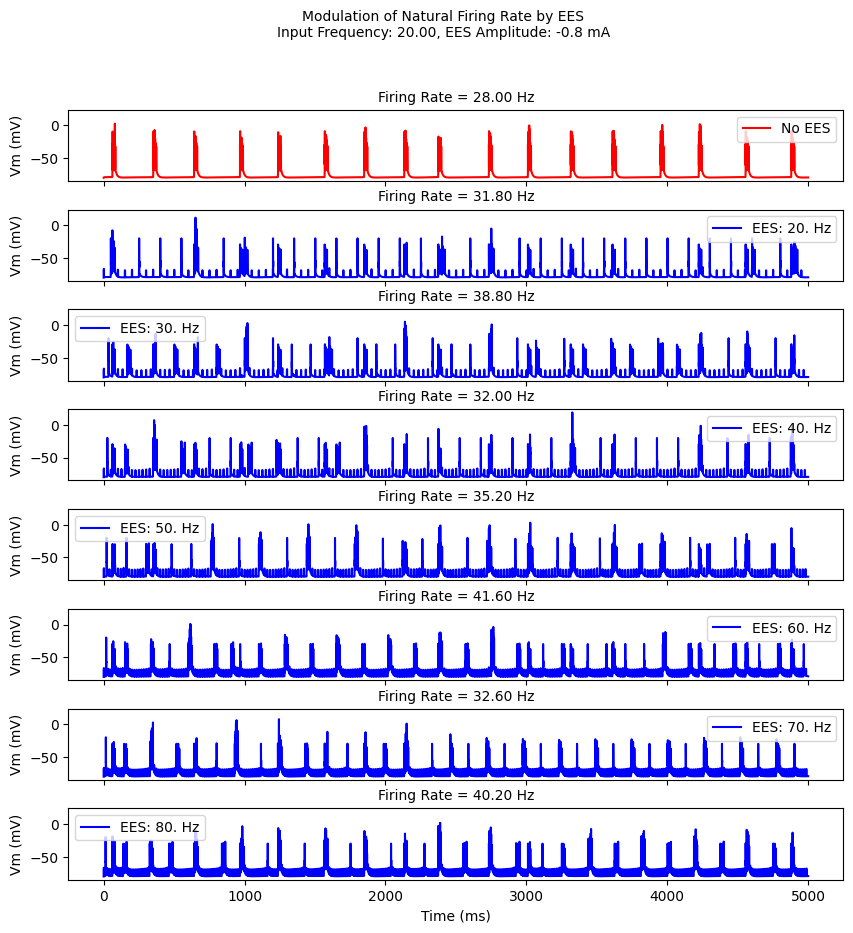

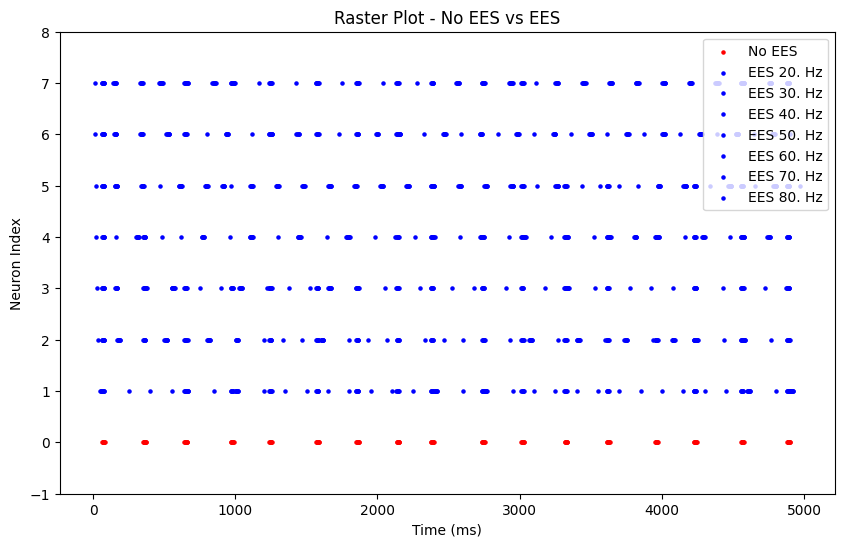

In [ ]:
# External Electrical Stimulation (EES) parameters
amplitude = -800 * uA  # Cathodal stimulation
ees_frequencies = [20, 30, 40, 50, 60, 70, 80] * Hz
input_frequency = 20 * Hz

# Run simulation
monitors = simulate(input_frequency=input_frequency, frequency_EES=ees_frequencies, I=amplitude)

# Prepare plotting
fig, axes = plt.subplots(len(ees_frequencies) + 1, 1, figsize=(10, 10), sharex=True, sharey=True)
fig_raster, ax_raster = plt.subplots(figsize=(10, 6))

# Plot no EES condition
v_without = monitors[0].v[0] / mV
t_without = monitors[0].t / ms
spike_times_without, f_without = firing_rate(t_without, v_without)
print(f"Natural Firing Rate (no EES): {f_without:.2f} Hz")

fig.suptitle(f"Modulation of Natural Firing Rate by EES\nInput Frequency: {input_frequency:.2f}, EES Amplitude: {amplitude}", fontsize=10)
fig.subplots_adjust(hspace=0.4)
axes[0].plot(t_without, v_without, color="red", label="No EES")
axes[0].set_title(f"Firing Rate = {f_without:.2f} Hz", fontsize=10)
axes[0].set_ylabel("Vm (mV)")
axes[0].legend(fontsize=10)

ax_raster.set_title("Raster Plot - No EES vs EES")
ax_raster.set_xlabel("Time (ms)")
ax_raster.set_ylabel("Neuron Index")
ax_raster.set_ylim(-1, len(ees_frequencies) + 1)
ax_raster.scatter(spike_times_without, np.zeros_like(spike_times_without), color='red', s=5, label="No EES")

# Plot each EES frequency condition
for j, frequency in enumerate(ees_frequencies):

    v_with = monitors[j + 1].v[0] / mV
    t_with = monitors[j + 1].t / ms
    spike_times_with, f_with = firing_rate(t_with, v_with)

    print(f"Firing Rate with EES  {frequency}: {f_with:.2f} Hz")

    ax = axes[j + 1]
    ax.plot(t_with, v_with, label=f"EES: {frequency}", color="blue")
    ax.set_title(f"Firing Rate = {f_with:.2f} Hz", fontsize=10)
    ax.set_ylabel("Vm (mV)")
    ax.legend(fontsize=10)

    ax_raster.scatter(spike_times_with, np.full_like(spike_times_with, j + 1), color='blue', s=5, label=f"EES {frequency}")

# Set labels only on last subplot
axes[-1].set_xlabel("Time (ms)")

# Finalize raster plot
handles, labels = ax_raster.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_raster.legend(by_label.values(), by_label.keys(), loc='upper right')

# Save figures
fig.savefig(f"voltage_trace_input_{input_frequency}_EES_{amplitude}.png", dpi=300)
fig_raster.savefig(f"raster_plot_input_{input_frequency}_EES_{amplitude}.png", dpi=300)

plt.show()


In [ ]:
import pandas as pd

lambda_nat = 20 * Hz  # Natural firing rate
ees_frequencies = [20,40,60,80] * hertz
T_refr = 10 * ms       # Refractory period
T_max = 1 * second    # Total simulation time
N=50 #nb of repetitions for the statistics

results = []
for n in range(N):

  monitors= simulate(input_frequency= lambda_nat, frequency_EES=ees_frequencies, I=-800* uA, T=T_max)

  Net=Network()
  G_nat = PoissonGroup(1, rates=lambda_nat)  # Natural firing
  M_nat = SpikeMonitor(G_nat)
  Net.add(G_nat, M_nat)
  Net.run(T_max)
  spike_times_nat = M_nat.spike_trains()[0]


  for j,ees_freq in enumerate(ees_frequencies):

      v_ = monitors[j+1].v[0] / mV
      t_ = monitors[j+1].t / ms
      spike_times, f_ = firing_rate(t_, v_)
      results.append({
                  'group': 'biophysics',
                  'frequency': ees_freq,
                  'value': f_
            })

      Net_ees=Network()
      G_ees = PoissonGroup(1, rates=ees_freq)  # Natural firing
      M_ees = SpikeMonitor(G_ees)
      Net_ees.add(G_ees, M_ees)
      Net_ees.run(T_max)
      spike_times_ees = M_ees.spike_trains()[0]
      final_spike_train=compute_final_firing_rate(spike_times_nat, spike_times_ees, T_refr)

      results.append({
                  'group': 'algo',
                  'frequency': ees_freq,
                  'value': (len(final_spike_train))/(T_max/second)
              })

df = pd.DataFrame(results)
df['frequency'] = df['frequency'].astype(float)
print(df)


iteration 0
after monitor
iteration 1
after monitor
iteration 2
after monitor
iteration 3
after monitor
iteration 4
after monitor
iteration 5
after monitor
iteration 6
after monitor
iteration 7
after monitor
iteration 8
after monitor
iteration 9
after monitor
iteration 10
after monitor
iteration 11
after monitor
iteration 12
after monitor
iteration 13
after monitor
iteration 14
after monitor
iteration 15
after monitor
iteration 16
after monitor
iteration 17
after monitor
iteration 18
after monitor
iteration 19
after monitor
iteration 20
after monitor
iteration 21
after monitor
iteration 22
after monitor
iteration 23
after monitor
iteration 24
after monitor
iteration 25
after monitor
iteration 26
after monitor
iteration 27
after monitor
iteration 28
after monitor
iteration 29
after monitor
iteration 30
after monitor
iteration 31
after monitor
iteration 32
after monitor
iteration 33
after monitor
iteration 34
after monitor
iteration 35
after monitor
iteration 36
after monitor
iteration 3

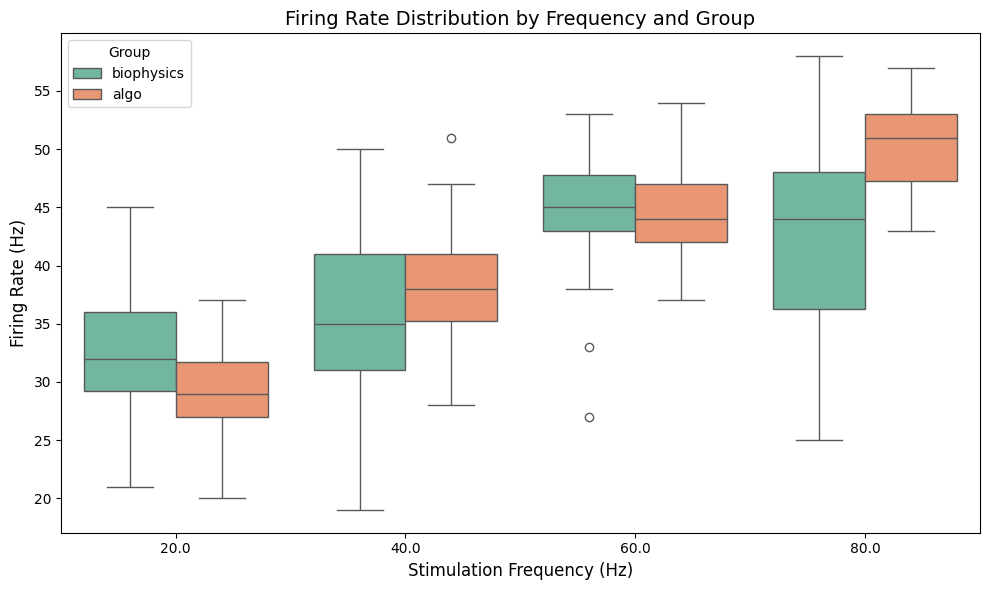

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="frequency", y="value", hue="group", palette="Set2")

plt.title("Firing Rate Distribution by Frequency and Group", fontsize=14)
plt.xlabel("Stimulation Frequency (Hz)", fontsize=12)
plt.ylabel("Firing Rate (Hz)", fontsize=12)
plt.legend(title="Group")
plt.tight_layout()
plt.savefig("firing_rate_distribution.png", dpi=300)
plt.show()

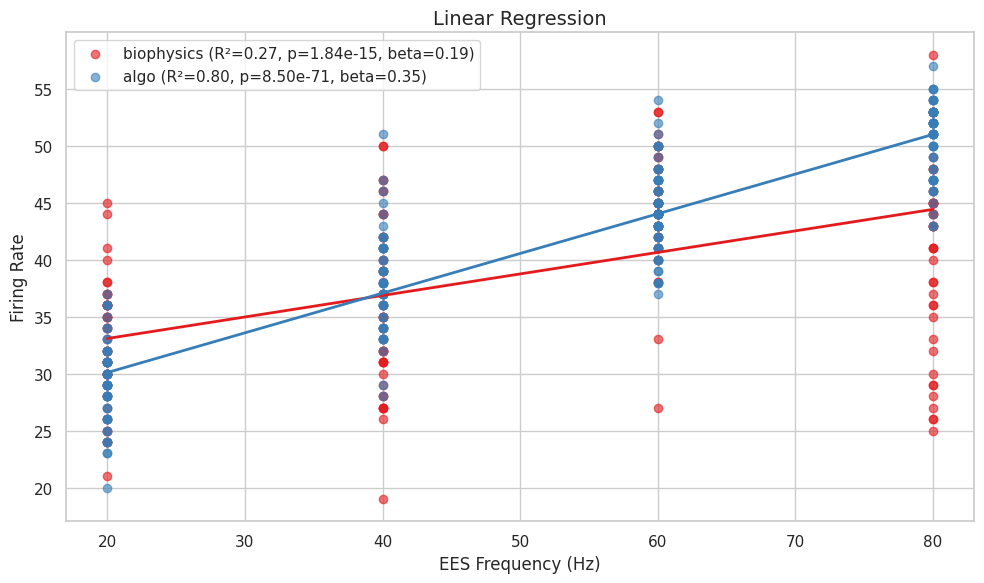

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# df should have columns: 'frequency', 'group', 'value'

# Set up plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
colors = sns.color_palette("Set1", n_colors=df['group'].nunique())

for i, group in enumerate(df['group'].unique()):
    sub_df = df[df['group'] == group]
    X = sub_df['frequency'].values
    y = sub_df['value'].values

    # Add constant for intercept in OLS
    X_with_const = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X_with_const).fit()
    y_pred = model.predict(X_with_const)

    # Extract regression stats
    slope = model.params[1]
    intercept = model.params[0]
    r_squared = model.rsquared
    p_value = model.pvalues[1]

    # Plot
    plt.scatter(X, y, label=f"{group} (R²={r_squared:.2f}, p={p_value:.2e}, beta={slope:.2f})", alpha=0.6, color=colors[i])
    plt.plot(X, y_pred, color=colors[i], linewidth=2)

# Final plot tweaks
plt.xlabel("EES Frequency (Hz)", fontsize=12)
plt.ylabel("Firing Rate", fontsize=12)
plt.title("Linear Regression", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


WARNING    'i' is an internal variable of group 'spatialneuron_15', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Natural Firing Rate (no EES): 26.60 Hz
Firing Rate with EES  20. Hz: 25.80 Hz
Firing Rate with EES  30. Hz: 25.40 Hz
Firing Rate with EES  40. Hz: 25.00 Hz
Firing Rate with EES  50. Hz: 23.40 Hz
Firing Rate with EES  60. Hz: 24.60 Hz
Firing Rate with EES  70. Hz: 23.20 Hz
Firing Rate with EES  80. Hz: 23.40 Hz


WARNING    'i' is an internal variable of group 'spatialneuron_22', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Natural Firing Rate (no EES): 24.00 Hz
Firing Rate with EES  20. Hz: 24.80 Hz
Firing Rate with EES  30. Hz: 25.00 Hz
Firing Rate with EES  40. Hz: 23.40 Hz
Firing Rate with EES  50. Hz: 21.80 Hz
Firing Rate with EES  60. Hz: 24.60 Hz
Firing Rate with EES  70. Hz: 24.60 Hz
Firing Rate with EES  80. Hz: 22.40 Hz
Natural Firing Rate (no EES): 27.20 Hz
Firing Rate with EES  20. Hz: 31.60 Hz
Firing Rate with EES  30. Hz: 36.80 Hz
Firing Rate with EES  40. Hz: 36.80 Hz
Firing Rate with EES  50. Hz: 34.00 Hz
Firing Rate with EES  60. Hz: 29.80 Hz
Firing Rate with EES  70. Hz: 32.00 Hz
Firing Rate with EES  80. Hz: 35.80 Hz


WARNING    'i' is an internal variable of group 'spatialneuron', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Natural Firing Rate (no EES): 26.00 Hz
Firing Rate with EES  20. Hz: 26.40 Hz
Firing Rate with EES  30. Hz: 34.40 Hz
Firing Rate with EES  40. Hz: 29.60 Hz
Firing Rate with EES  50. Hz: 35.40 Hz
Firing Rate with EES  60. Hz: 34.40 Hz
Firing Rate with EES  70. Hz: 38.00 Hz
Firing Rate with EES  80. Hz: 36.40 Hz
Natural Firing Rate (no EES): 26.20 Hz
Firing Rate with EES  20. Hz: 26.00 Hz
Firing Rate with EES  30. Hz: 26.80 Hz
Firing Rate with EES  40. Hz: 25.60 Hz
Firing Rate with EES  50. Hz: 26.60 Hz
Firing Rate with EES  60. Hz: 25.80 Hz
Firing Rate with EES  70. Hz: 31.00 Hz
Firing Rate with EES  80. Hz: 29.80 Hz


WARNING    'i' is an internal variable of group 'spatialneuron_23', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Natural Firing Rate (no EES): 26.20 Hz
Firing Rate with EES  20. Hz: 30.40 Hz
Firing Rate with EES  30. Hz: 31.00 Hz
Firing Rate with EES  40. Hz: 30.80 Hz
Firing Rate with EES  50. Hz: 29.20 Hz
Firing Rate with EES  60. Hz: 28.80 Hz
Firing Rate with EES  70. Hz: 27.40 Hz
Firing Rate with EES  80. Hz: 27.80 Hz


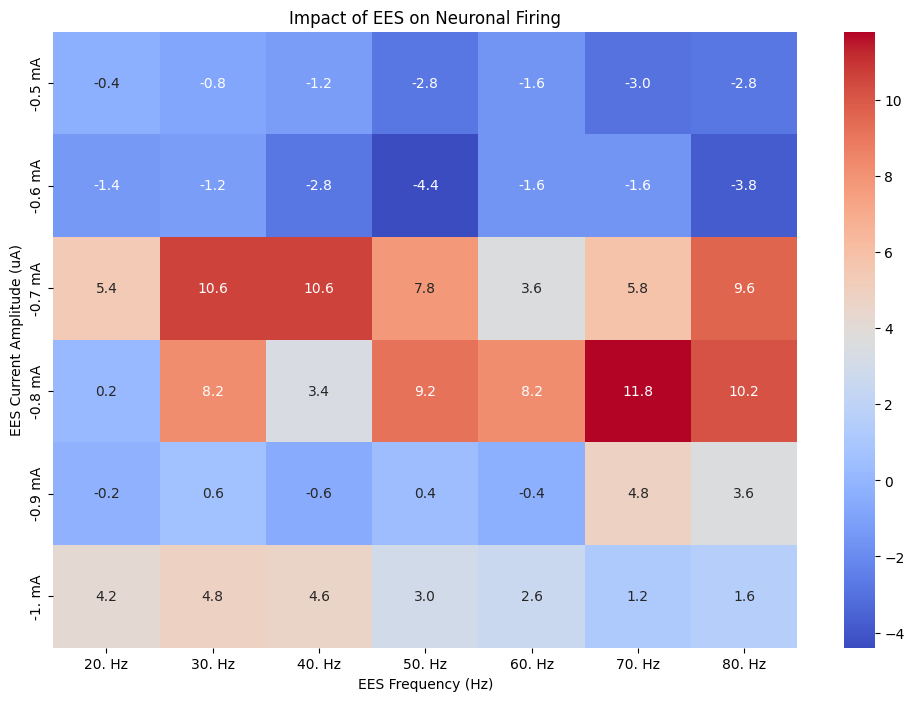

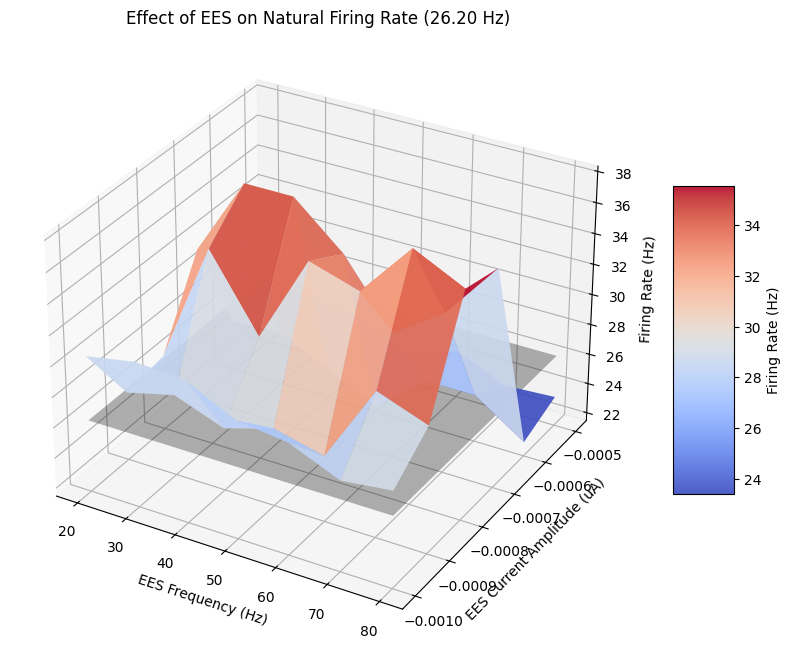

In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

amplitudes=[-500, -600, -700, -800, -900, -1000]*uA
ees_frequencies = [20,30,40,50,60,70,80] * hertz
firing_rates=np.zeros((len(amplitudes), len(ees_frequencies)))

for i, current in enumerate(amplitudes):
    monitors= simulate(input_frequency= 20*hertz, frequency_EES=ees_frequencies, I=current)
    v_without = monitors[0].v[0] / mV
    t_without = monitors[0].t / ms
    spike_times_without, f_without = firing_rate(t_without, v_without)
    print(f"Natural Firing Rate (no EES): {f_without:.2f} Hz")
    for j, freq in enumerate(ees_frequencies):
        v__ = monitors[j+1].v[0] / mV
        t__ = monitors[j+1].t / ms
        spike_times, f__ = firing_rate(t__, v__)
        print(f"Firing Rate with EES  {freq}: {f__:.2f} Hz")
        firing_rates[i,j]=f__

# Heatmap Plot
plt.figure(figsize=(12, 8))
sns.heatmap(firing_rates-f_without, xticklabels=ees_frequencies, yticklabels=amplitudes, cmap="coolwarm", annot=True, fmt=".1f")
plt.xlabel("EES Frequency (Hz)")
plt.ylabel("EES Current Amplitude (uA)")
plt.title(f"Impact of EES on Neuronal Firing")

heatmap_filename = f"heatmap.png"
plt.savefig(heatmap_filename, dpi=300)
plt.show()

#3D Surface Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(ees_frequencies, amplitudes)
Z = firing_rates  # Firing rates from simulations

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap="coolwarm", alpha=0.9)

# Add a reference plane at natural firing rate
ax.plot_surface(X, Y, np.full_like(Z, f_without), color='black', alpha=0.3)  # Transparent plane

# Labels and title
ax.set_xlabel("EES Frequency (Hz)")
ax.set_ylabel("EES Current Amplitude (uA)")
ax.set_zlabel("Firing Rate (Hz)")
ax.set_title(f"Effect of EES on Natural Firing Rate ({f_without:.2f} Hz)")

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label="Firing Rate (Hz)")

surface_filename = f"3D_plot.png"
plt.savefig(surface_filename, dpi=300)
plt.show()

Natural Firing Rate (no EES): 18.00 Hz
Firing Rate with EES  20. Hz: 18.20 Hz
Firing Rate with EES  30. Hz: 16.40 Hz
Firing Rate with EES  40. Hz: 16.60 Hz
Firing Rate with EES  50. Hz: 16.80 Hz
Firing Rate with EES  60. Hz: 16.60 Hz
Firing Rate with EES  70. Hz: 16.80 Hz
Firing Rate with EES  80. Hz: 16.40 Hz
Natural Firing Rate (no EES): 22.80 Hz
Firing Rate with EES  20. Hz: 23.00 Hz
Firing Rate with EES  30. Hz: 22.00 Hz
Firing Rate with EES  40. Hz: 20.20 Hz
Firing Rate with EES  50. Hz: 21.20 Hz
Firing Rate with EES  60. Hz: 20.80 Hz
Firing Rate with EES  70. Hz: 20.00 Hz
Firing Rate with EES  80. Hz: 18.80 Hz
Natural Firing Rate (no EES): 25.40 Hz
Firing Rate with EES  20. Hz: 25.60 Hz
Firing Rate with EES  30. Hz: 24.40 Hz
Firing Rate with EES  40. Hz: 24.20 Hz
Firing Rate with EES  50. Hz: 24.80 Hz
Firing Rate with EES  60. Hz: 24.40 Hz
Firing Rate with EES  70. Hz: 24.60 Hz
Firing Rate with EES  80. Hz: 24.60 Hz
Natural Firing Rate (no EES): 25.60 Hz
Firing Rate with EES  20.

WARNING    'i' is an internal variable of group 'spatialneuron_23', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Natural Firing Rate (no EES): 24.60 Hz
Firing Rate with EES  20. Hz: 24.20 Hz
Firing Rate with EES  30. Hz: 23.80 Hz
Firing Rate with EES  40. Hz: 22.00 Hz
Firing Rate with EES  50. Hz: 23.40 Hz
Firing Rate with EES  60. Hz: 22.40 Hz
Firing Rate with EES  70. Hz: 21.80 Hz
Firing Rate with EES  80. Hz: 22.20 Hz
Natural Firing Rate (no EES): 26.20 Hz
Firing Rate with EES  20. Hz: 26.40 Hz
Firing Rate with EES  30. Hz: 23.00 Hz
Firing Rate with EES  40. Hz: 25.40 Hz
Firing Rate with EES  50. Hz: 22.60 Hz
Firing Rate with EES  60. Hz: 21.20 Hz
Firing Rate with EES  70. Hz: 23.00 Hz
Firing Rate with EES  80. Hz: 25.40 Hz


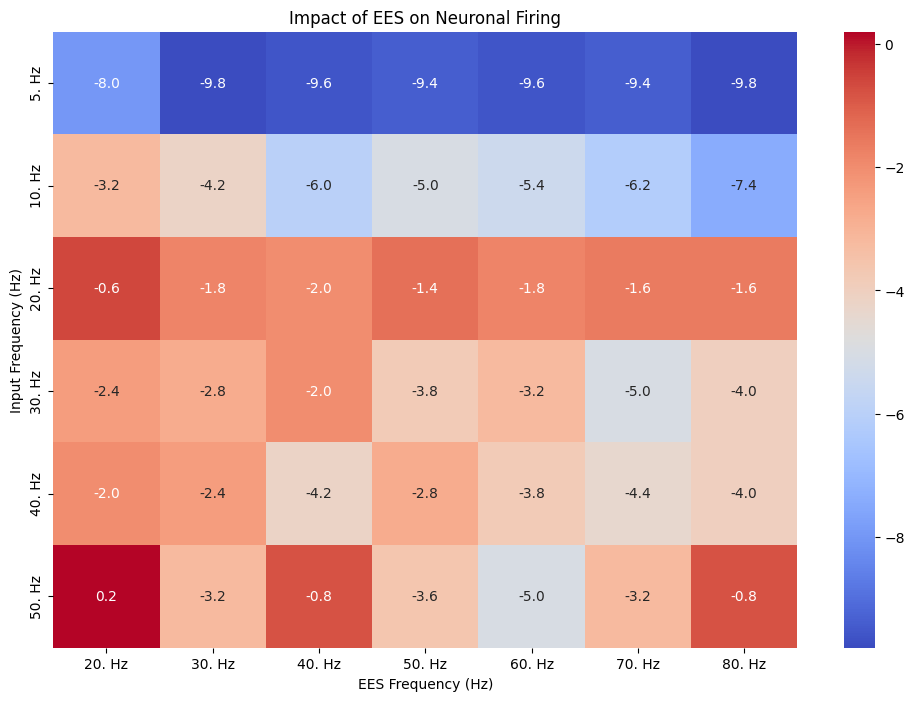

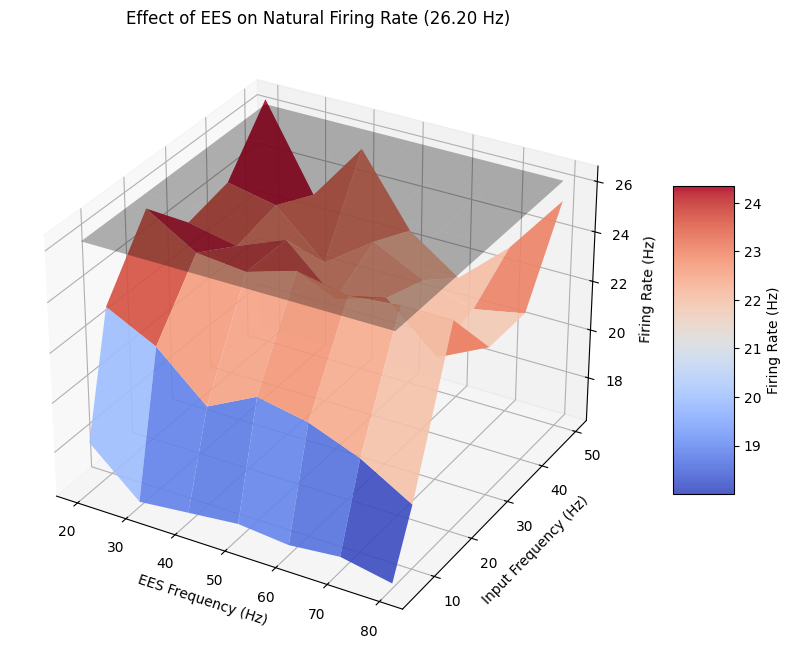

In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

inputs=[5, 10, 20, 30, 40, 50]*hertz
ees_frequencies = [20,30,40,50,60,70,80] * hertz
firing_rates=np.zeros((len(inputs), len(ees_frequencies)))

for i, input in enumerate(inputs):
    monitors= simulate(input_frequency= input, frequency_EES=ees_frequencies, I=-600*uA)
    v_without = monitors[0].v[0] / mV
    t_without = monitors[0].t / ms
    spike_times_without, f_without = firing_rate(t_without, v_without)
    print(f"Natural Firing Rate (no EES): {f_without:.2f} Hz")
    for j, freq in enumerate(ees_frequencies):
        v__ = monitors[j+1].v[0] / mV
        t__ = monitors[j+1].t / ms
        spike_times, f__ = firing_rate(t__, v__)
        print(f"Firing Rate with EES  {freq}: {f__:.2f} Hz")
        firing_rates[i,j]=f__

# Heatmap Plot
plt.figure(figsize=(12, 8))
sns.heatmap(firing_rates-f_without, xticklabels=ees_frequencies, yticklabels=inputs, cmap="coolwarm", annot=True, fmt=".1f")
plt.xlabel("EES Frequency (Hz)")
plt.ylabel("Input Frequency (Hz)")
plt.title(f"Impact of EES on Neuronal Firing")

heatmap_filename = f"heatmap.png"
plt.savefig(heatmap_filename, dpi=300)
plt.show()

#3D Surface Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(ees_frequencies, inputs)
Z = firing_rates  # Firing rates from simulations

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap="coolwarm", alpha=0.9)

# Add a reference plane at natural firing rate
ax.plot_surface(X, Y, np.full_like(Z, f_without), color='black', alpha=0.3)  # Transparent plane

# Labels and title
ax.set_xlabel("EES Frequency (Hz)")
ax.set_ylabel("Input Frequency (Hz)")
ax.set_zlabel("Firing Rate (Hz)")
ax.set_title(f"Effect of EES on Natural Firing Rate ({f_without:.2f} Hz)")

# Color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label="Firing Rate (Hz)")

surface_filename = f"3D_plot.png"
plt.savefig(surface_filename, dpi=300)
plt.show()